# [Unnamed Company] EEG Blink Detection

----
All code below is written by Arnold Yeung (2020-09-01).

In [111]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve
from sklearn.externals import joblib

from IPython.display import display 
import warnings
warnings.filterwarnings('ignore')

r_seed = 101

## Question 1: Machine Learning

EEG data was collected during an eyes open/closed task. A challenge that we face while processing EEG signals for neurotech applications (including biofeedback for meditation purposes) is artifact removal. Blinks and eye movements are one of the primary sources of interference in the raw EEG signal being processed. In this exercise, your problem statement is to develop an eyes open-closed classification algorithm for EEG signals.

The EEG data collected on all 4 channels was sampled at 256 Hz. The data was epoched using a moving window of 1 second window length and 1 second step size (1 second non-overlapping windows). 

- `q1_training_data.npy` contains the training set of EEG epochs with shape (n_epochs, n_channels, n_samples_per_epoch).
- `q1_training_labels.npy` contains the labels for each epoch of the training set and has shape (n_epochs).
- `q1_test_data.npy` contains the test set of EEG epochs with shape (n_epochs, n_channels, n_samples_per_epoch).

The deliverables for this part of the coding test is to generate predictions for the test set. Also, provide performance metrics for validation of the training set.

### Load data and labels

In [112]:
training_data = np.load('q1_training_data.npy')
training_labels = np.load('q1_training_labels.npy')
test_data = np.load('q1_test_data.npy')

sampling_rate = 256

n_train, n_channels, n_samples = training_data.shape
n_test = test_data.shape[0]

print("Num channels: ", n_channels)
print("Sampling rate: ", n_samples)
print("Training data: ", n_train)
print("Test data: ", n_test)


Num channels:  4
Sampling rate:  256
Training data:  912
Test data:  171


Convert the training labels into binary labels.

In [113]:
binary_training_labels = []
for i in range(0, len(training_labels)):
    if training_labels[i] == "eyes_open":
        binary_training_labels.append(1)
    else:
        binary_training_labels.append(0)

training_labels = binary_training_labels

Because some of the training data is `nan`, we remove entries which contain `nan`.

In [114]:
nan_idx = tuple(np.argwhere(np.isnan(training_data))[:, 0])
training_data = np.delete(training_data, nan_idx, axis=0)
training_labels = np.delete(training_labels, nan_idx, axis=0)

np.isnan(training_data).any()
np.argwhere(np.isnan(training_data))

array([], shape=(0, 3), dtype=int64)

### Feature Processing
Because the relative time of a sample in each epoch should not have any correlation with the label, we convert the data into the frequency domain, such that it is temporally-independent. 

We hypothesize that there would be significant differences between the two classes in the frequency domain.

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]


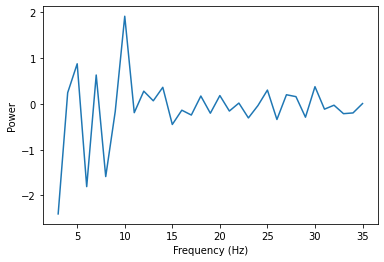

In [115]:
def get_index_in_freq(freq, frequencies):
    """
    Get the index of the element in frequencies which is equal to or less than freq 
    """
    index = 0
    for i in range(0, len(frequencies)):
        if frequencies[i] > freq:
            return index
        else:
            index = i

def convert_to_fft(data, sampling_rate, freq_range=[1, 35]):
    """
    Converts the numpy data (n_epochs, n_channels, n_samples) to real component of FFT features 
    (n_epochs, n_channels * n_features).
    """
    if len(data.shape) != 3:
        raise ValueError("Wrong data size.")
    
    time_period = data.shape[-1]/sampling_rate
    frequencies = np.arange(data.shape[-1])/time_period

    min_freq_idx = get_index_in_freq(freq_range[0], frequencies)
    max_freq_idx = get_index_in_freq(freq_range[1], frequencies)
    frequencies = frequencies[min_freq_idx:max_freq_idx+1]
    
    fft_features = (np.fft.fft(data, axis=-1)/data.shape[-1])[:, :, min_freq_idx:max_freq_idx+1].real
    
    return frequencies, fft_features

def plot_fft(frequencies, fft_features):
    """
    Plot numpy array (n_samples, )
    """
    axis = plt.plot(frequencies, fft_features)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")

frequencies, fft_features = convert_to_fft(training_data, sampling_rate)
print(frequencies)
plot_fft(frequencies[2:], fft_features[1][0][2:])


In [116]:
frequencies, fft_train = convert_to_fft(training_data, sampling_rate)
_, fft_test = convert_to_fft(test_data, sampling_rate)

n_train, n_channels, n_features = fft_train.shape
n_test, _, _ = fft_test.shape

# flatten features
fft_train = fft_train.reshape((n_train, n_channels * n_features))
fft_test = fft_test.reshape((n_test, n_channels * n_features))

print("There are a total of ", fft_train.shape[-1], " features.")

There are a total of  140  features.


### Split into test, validation, and training set
We now split the training dataset into training, validation, and test. We use a 80-10-10 split.  Note that this test set is different from the provided one.  This test set is used for measuring the accuracy and is labeled.

In [117]:
# combine labels with features
fft_train = np.hstack((fft_train, np.array([training_labels]).transpose()))
print(fft_train.shape)

(904, 141)


In [118]:
ratio = {'train': 0.8, 'valid': 0.10, 'test': 0.10}
valid_test_data, train_data = train_test_split(fft_train, test_size=ratio['train'], random_state=r_seed)

split_ratio = float(ratio['valid']/(ratio['valid']+ratio['test']))
tvalid_data, ttest_data = train_test_split(valid_test_data, test_size=split_ratio, random_state=r_seed)

In [119]:
# separate features from labels
train_feats, train_labels = train_data[:, :-1], train_data[:, -1]
tvalid_feats, tvalid_labels = tvalid_data[:, :-1], tvalid_data[:, -1]
ttest_feats, ttest_labels = ttest_data[:, :-1], ttest_data[:, -1]

In [120]:
scaler = MinMaxScaler()

scaler.fit(train_feats)
train_feats = scaler.transform(train_feats)
tvalid_feats = scaler.transform(tvalid_feats)
ttest_feats = scaler.transform(ttest_feats)

np.isnan(train_labels).any()
np.argwhere(np.isnan(train_labels))

array([], shape=(0, 1), dtype=int64)

### Traditional ML Model Fitting

In [121]:
if not os.path.exists('models'):
    os.makedirs('models')

scaler_filename = "./models/scaler.pkl"
_ = joblib.dump(scaler, scaler_filename)

model_filenames = {
             'LogisticRegression': "./models/lr.pkl",
             'RandomForest': "./models/rf.pkl",
             'SVM': "./models/svm.pkl"
            }

top_model_configs = {}

def train_logistic_regression(train_feats, train_labels, valid_feats, valid_labels):
    
    scores = {'penalty': [], 'C': [], 'train_acc': [], 'valid_acc': []}
    
    # parameters
    penalties = ['none']
    Cs = np.arange(0, 1.0+0.1, 0.1)
    
    max_acc = None
    
    for penalty in penalties:
        for C in Cs:
            logistic_regression = LogisticRegression(penalty=penalty, C=C)
            logistic_regression.fit(train_feats, train_labels)
            
            train_predict = logistic_regression.predict(train_feats)
            valid_predict = logistic_regression.predict(valid_feats)
            valid_acc = accuracy_score(valid_labels, valid_predict)
            train_acc = accuracy_score(train_labels, train_predict)

            if max_acc is None or valid_acc > max_acc:
                max_acc = valid_acc
                top_model_configs['LogisticRegression'] = {'penalty': penalty,
                                                           'C': C,
                                                           'valid_acc': valid_acc,
                                                           'train_acc': train_acc}
                _ = joblib.dump(logistic_regression, model_filenames['LogisticRegression'])
            
            scores['penalty'].append(penalty)
            scores['C'].append(C)
            scores['train_acc'].append(train_acc)
            scores['valid_acc'].append(valid_acc)
    scores = pd.DataFrame.from_dict(scores)
    return scores

def train_support_vector_machine(train_feats, train_labels, valid_feats, valid_labels):
    
    scores = {'kernel': [], 'C': [], 'train_acc': [], 'valid_acc': []}
    
    # parameters
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    Cs = np.arange(0.1, 1.0+0.1, 0.1)
    
    max_acc = None
    
    for kernel in kernels:
        for C in Cs:
            classifier = SVC(kernel=kernel, C=C)
            classifier.fit(train_feats, train_labels)
            
            train_predict = classifier.predict(train_feats)
            valid_predict = classifier.predict(valid_feats)
            valid_acc = accuracy_score(valid_labels, valid_predict)
            train_acc = accuracy_score(train_labels, train_predict)

            if max_acc is None or valid_acc > max_acc:
                max_acc = valid_acc
                top_model_configs['SVM'] = {'kernel': kernel,
                                            'C': C,
                                            'valid_acc': valid_acc,
                                            'train_acc': train_acc}
                _ = joblib.dump(classifier, model_filenames['SVM'])
            
            scores['kernel'].append(kernel)
            scores['C'].append(C)
            scores['train_acc'].append(train_acc)
            scores['valid_acc'].append(valid_acc)
    scores = pd.DataFrame.from_dict(scores)
    return scores

def train_random_forest(train_feats, train_labels, valid_feats, valid_labels):
    
    scores = {'n_estimators': [], 'criterion': [], 'max_depth': [], 'min_samples_split': [],
              'train_acc': [], 'valid_acc': []}
    
    # parameters
    ns_estimators = [1, 2, 5, 10, 20, 50, 100]
    criterions = ['gini', 'entropy']
    max_depths = [5, 10, 20, 50]
    min_samples_splits = [2, 5, 10, 20]
    
    max_acc = None
    
    for n_estimators in ns_estimators:
        for criterion in criterions:
            for max_depth in max_depths:
                for min_samples_split in min_samples_splits:
                    classifier = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, 
                                                       max_depth=max_depth, min_samples_split=min_samples_split,
                                                       random_state=r_seed)
                    classifier.fit(train_feats, train_labels)

                    train_predict = classifier.predict(train_feats)
                    valid_predict = classifier.predict(valid_feats)
                    valid_acc = accuracy_score(valid_labels, valid_predict)
                    train_acc = accuracy_score(train_labels, train_predict)

                    if max_acc is None or valid_acc > max_acc:
                        max_acc = valid_acc
                        top_model_configs['RandomForest'] = {'n_estimators': n_estimators,
                                                             'criterion': criterion,
                                                             'max_depth': max_depth,
                                                             'min_samples_split': min_samples_split,
                                                             'valid_acc': valid_acc,
                                                             'train_acc': train_acc}
                        _ = joblib.dump(classifier, model_filenames['RandomForest'])

                    scores['n_estimators'].append(n_estimators)
                    scores['criterion'].append(criterion)
                    scores['max_depth'].append(max_depth)
                    scores['min_samples_split'].append(min_samples_split)
                    scores['train_acc'].append(train_acc)
                    scores['valid_acc'].append(valid_acc)
    scores = pd.DataFrame.from_dict(scores)
    return scores

In [122]:
lr_scores = train_logistic_regression(train_feats, train_labels, tvalid_feats, tvalid_labels)
svm_scores = train_support_vector_machine(train_feats, train_labels, tvalid_feats, tvalid_labels)
rf_scores = train_random_forest(train_feats, train_labels, tvalid_feats, tvalid_labels)

In [123]:
top_model_configs

{'LogisticRegression': {'C': 0.0,
  'penalty': 'none',
  'train_acc': 0.8024861878453039,
  'valid_acc': 0.6444444444444445},
 'RandomForest': {'criterion': 'entropy',
  'max_depth': 20,
  'min_samples_split': 10,
  'n_estimators': 2,
  'train_acc': 0.8825966850828729,
  'valid_acc': 0.8111111111111111},
 'SVM': {'C': 0.1,
  'kernel': 'linear',
  'train_acc': 0.6975138121546961,
  'valid_acc': 0.7555555555555555}}

We now obtain the best model based on the validation accuracy.

In [124]:
top_model_name = None
top_valid_acc = None
for model in top_model_configs:
    if top_model_name is None or top_model_configs[model]['valid_acc'] > top_valid_acc:
        top_model_name = model
        top_valid_acc = top_model_configs[model]['valid_acc']

print("The top model is", top_model_name, "with a validation accuracy of", top_valid_acc, ".")

The top model is RandomForest with a validation accuracy of 0.8111111111111111 .


We now run this model for the test data which find an approximate test accuracy.

The test accuracy for LogisticRegression  is 0.6
The test accuracy for RandomForest  is 0.7
The test accuracy for SVM  is 0.6777777777777778


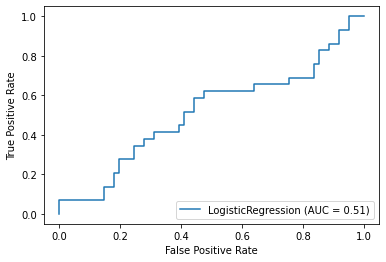

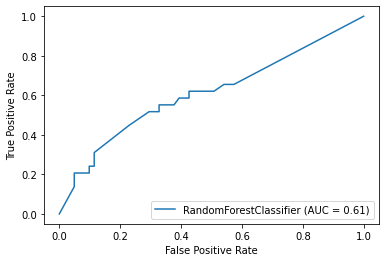

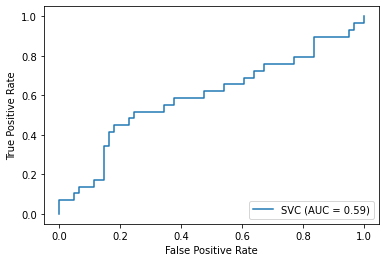

In [125]:
for model in model_filenames:
  clf = joblib.load(model_filenames[model])
  ttest_predict = clf.predict(ttest_feats)
  ttest_acc = accuracy_score(ttest_labels, ttest_predict)

  print("The test accuracy for", model, " is", ttest_acc)
  
  plot_roc_curve(clf, ttest_feats, ttest_labels)

### Predict Test Set using Traditional ML
We now predict the labels of the test data.  We save the output predictions to `q1_test_labels.npy`.  Note that we do not predict for data which contains `NaN`.

In [126]:
def run_prediction(scaler_file, clf_file, data):
    scaler = joblib.load(scaler_file)
    clf = joblib.load(clf_file)
    
    # automatically return NaN for epochs with NaN 
    nan_indices = set(np.argwhere(np.isnan(data))[:, 0])    
    
    n_epochs = data.shape[0]
    predict_labels = []

    if nan_indices:
        valid_epochs = [x for x in range(0, n_epochs) if x not in nan_indices]
        for epoch in range(0, n_epochs):
            if epoch in valid_epochs:
                prediction = clf.predict(scaler.transform(np.array([data[epoch, :]])))[0]
                predict_labels.append(prediction)
            else:
                print("Epoch ", epoch, " contains NaN and cannot be predicted for.")
                predict_labels.append(np.nan)
    else:
        predict_labels = clf.predict(scaler.transform(data))
    
    # convert ot numpy array
    if not isinstance(predict_labels, np.ndarray):
        predict_labels = np.array(predict_labels)
    
    return predict_labels

In [127]:
predict_labels = run_prediction(scaler_filename, model_filenames[top_model_name], fft_test)
display(predict_labels)
np.save('q1_test_labels.npy', predict_labels)

Epoch  169  contains NaN and cannot be predicted for.


array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
        1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
       nan,  0.])

### Deep Learning Model Fitting
We use Keras to implement a RNN which captures the temporal features within the data. We use a many-to-one unidirectional LSTM architecture.

In [128]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Concatenate, Reshape, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, load_model

from sklearn.utils import class_weight

from numpy.random import seed
seed(r_seed)
from tensorflow.random import set_seed
set_seed(r_seed)

In [129]:
class LSTM_RNN():

  def __init__(self, params):
    self.n_epochs = params['n_epochs']
    self.n_timesteps = params['n_timesteps']
    self.n_features = params['n_features']
    self.n_output_dim = params['n_output_dim']
    self.n_hidden_units = params['n_hidden_units']
    self.activation = params['activation']
    self.batch_size = params['batch_size']
    self.train_epochs = params['train_epochs']
    self.unbalanced = params['unbalanced']
    self.dropout = params['dropout']
    self.lr = params['learning_rate']


    self.model = Sequential()
    self.model.add(Input(shape=(self.n_timesteps, self.n_features)))
    self.model.add(Dropout(self.dropout))
    self.model.add(Dense(self.n_hidden_units, self.activation, 
                         kernel_regularizer=keras.regularizers.l2()))
    self.model.add(BatchNormalization())
    self.model.add(Dropout(self.dropout))
    self.model.add(LSTM(self.n_hidden_units, self.activation, 
                        input_shape = (self.n_timesteps, self.n_features)))
    self.model.add(Dense(self.n_output_dim, activation="sigmoid",
                         kernel_regularizer=keras.regularizers.l2()))

    opt = keras.optimizers.Adam(learning_rate=self.lr)
    self.model.compile(optimizer=opt, loss='binary_crossentropy', 
                       metrics=['accuracy'])
    print(self.model.summary())
  
  def fit(self, train_feats, train_labels, valid_feats, valid_labels):

    # calculate weights of each class -- unbalanced dataset
    if self.unbalanced:
      class_weights = class_weight.compute_class_weight('balanced',
                                                        np.unique(train_labels),
                                                        train_labels)
      class_weights = {i : class_weights[i] for i in range(0, len(class_weights))}
      print("Using class_weights of ", class_weights)

      history = self.model.fit(train_feats, train_labels, 
                              batch_size=self.batch_size, epochs=self.train_epochs,
                              validation_data=(valid_feats, valid_labels),
                              class_weight=class_weights,
                              verbose=1)
    else:
      history = self.model.fit(train_feats, train_labels, 
                              batch_size=self.batch_size, epochs=self.train_epochs,
                              validation_data=(valid_feats, valid_labels),
                              verbose=1)
    return history

  def predict(self, feats):
    return self.model.predict(feats, verbose=1)
  
  def save(self, filename):
    self.model.save(filename)


class LSTM_RNN_fft():

  def __init__(self, params):
    self.n_epochs = params['n_epochs']
    self.n_timesteps = params['n_timesteps']
    self.n_features = params['n_features']
    self.n_output_dim = params['n_output_dim']
    self.n_hidden_units = params['n_hidden_units']
    self.activation = params['activation']
    self.batch_size = params['batch_size']
    self.train_epochs = params['train_epochs']
    self.unbalanced = params['unbalanced']
    self.dropout = params['dropout']
    self.lr = params['learning_rate']

    inputs = Input(shape=(self.n_timesteps, self.n_features))

    # FFT pipeline
    reshaped_inputs = Reshape(target_shape=(self.n_features, self.n_timesteps))(inputs)
    fft_inputs = tf.cast(tf.signal.fft(tf.cast(reshaped_inputs, dtype=tf.complex64)), 
                         dtype=tf.float32)
    
    fft_feature_size = fft_inputs.shape[-1] * fft_inputs.shape[-2]

    self.fft_model = Sequential()
    self.fft_model.add(Dropout(self.dropout))
    self.fft_model.add(BatchNormalization())
    self.fft_model.add(Reshape(target_shape=(fft_feature_size,)))
    self.fft_model.add(Dense(2*self.n_hidden_units, self.activation, 
                             kernel_regularizer=keras.regularizers.l2()))
    self.fft_model.add(Dropout(self.dropout))
    self.fft_model.add(Dense(self.n_hidden_units, self.activation,
                             kernel_regularizer=keras.regularizers.l2()))
    fft_outputs = self.fft_model(fft_inputs)

    # RNN pipeline
    self.rnn_model = Sequential()
    self.rnn_model.add(Dropout(self.dropout))
    self.rnn_model.add(Dense(self.n_hidden_units, self.activation, 
                             kernel_regularizer=keras.regularizers.l2()))
    self.rnn_model.add(BatchNormalization())
    self.rnn_model.add(Dropout(self.dropout))
    self.rnn_model.add(LSTM(self.n_hidden_units, self.activation, 
                        input_shape = (self.n_timesteps, self.n_features)))
    rnn_outputs = self.rnn_model(inputs)

    # combined pipeline
    concatenated = Concatenate(axis=-1)([fft_outputs, rnn_outputs])
    outputs = Dense(self.n_output_dim, activation="sigmoid",
                    kernel_regularizer=keras.regularizers.l2())(concatenated)

    self.model = Model(inputs, outputs)

    opt = keras.optimizers.Adam(learning_rate=self.lr)
    self.model.compile(optimizer=opt, loss='binary_crossentropy', 
                       metrics=['accuracy'])
    print(self.model.summary())
  
  def fit(self, train_feats, train_labels, valid_feats, valid_labels):

    # calculate weights of each class -- unbalanced dataset
    if self.unbalanced:
      class_weights = class_weight.compute_class_weight('balanced',
                                                        np.unique(train_labels),
                                                        train_labels)
      class_weights = {i : class_weights[i] for i in range(0, len(class_weights))}
      print("Using class_weights of ", class_weights)

      history = self.model.fit(train_feats, train_labels, 
                              batch_size=self.batch_size, epochs=self.train_epochs,
                              validation_data=(valid_feats, valid_labels),
                              class_weight=class_weights,
                              verbose=1)
    else:
      history = self.model.fit(train_feats, train_labels, 
                              batch_size=self.batch_size, epochs=self.train_epochs,
                              validation_data=(valid_feats, valid_labels),
                              verbose=1)
    return history

  def predict(self, feats):
    return self.model.predict(feats, verbose=1)
  
  def save(self, filename):
    self.model.save(filename)


In [130]:
print(training_data.shape)

(904, 4, 256)


We reshape the training and test data to (n_epochs, n_timesteps, n_features).



In [131]:
rnn_training_data = training_data.reshape((training_data.shape[0], 
                                           training_data.shape[2], training_data.shape[1]))

rnn_test_data = test_data.reshape((test_data.shape[0], test_data.shape[2], 
                                  test_data.shape[1]))

We split the training dataset into training, validation, and test sets.

In [132]:
ratio = {'train': 0.8, 'valid': 0.10, 'test': 0.10}

valid_test_feats, train_feats, valid_test_labels, train_labels = train_test_split(rnn_training_data, training_labels,
                                                                                  test_size=ratio['train'], random_state=r_seed)

split_ratio = float(ratio['valid']/(ratio['valid']+ratio['test']))
tvalid_feats, ttest_feats, tvalid_labels, ttest_labels = train_test_split(valid_test_feats, 
                                                                          valid_test_labels,
                                                                          test_size=split_ratio, 
                                                                          random_state=r_seed)

We create instances of our LSTM RNN model and FFT LSTM model and train them using the training data.

In [133]:
params = {
   'n_epochs':        training_data.shape[0],
   'n_timesteps':     training_data.shape[2],
   'n_features':      training_data.shape[1],
   'n_output_dim':    1,
   'n_hidden_units':  10,
   'activation':      'relu',
   'batch_size':      64,
   'train_epochs':    100,
   'unbalanced':      True,
   'dropout':         0.3,
   'learning_rate':   0.001,

}

rnn_filename = "./models/lstm.h5"

clf = LSTM_RNN(params)
rnn_history = clf.fit(train_feats, train_labels, tvalid_feats, tvalid_labels)
clf.save(rnn_filename)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_12 (Dropout)         (None, 256, 4)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 256, 10)           50        
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 10)           40        
_________________________________________________________________
dropout_13 (Dropout)         (None, 256, 10)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 941
Trainable params: 921
Non-trainable params: 20
_______________________________________________________

In [134]:
params = {
   'n_epochs':        training_data.shape[0],
   'n_timesteps':     training_data.shape[2],
   'n_features':      training_data.shape[1],
   'n_output_dim':    1,
   'n_hidden_units':  10,
   'activation':      'relu',
   'batch_size':      64,
   'train_epochs':    100,
   'unbalanced':      True,
   'dropout':         0.5,
   'learning_rate':   0.001,

}

fft_filename = "./models/lstm_fft.h5"

clf = LSTM_RNN_fft(params)
fft_history = clf.fit(train_feats, train_labels, tvalid_feats, tvalid_labels)
clf.save(fft_filename)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 4)]     0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 4, 256)       0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Cast_4 (TensorFlowO [(None, 4, 256)]     0           reshape_4[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_FFT_2 (TensorFlowOp [(None, 4, 256)]     0           tf_op_layer_Cast_4[0][0]         
_______________________________________________________________________________________

We plot the losses and accuracies during the training epochs for both models.

Text(0, 0.5, 'Accuracy')

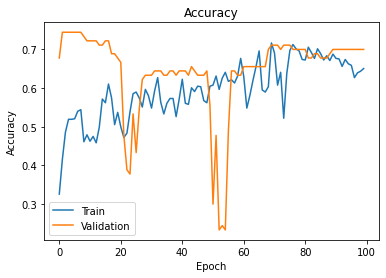

In [135]:
axis = plt.plot(rnn_history.history['accuracy'])
plt.plot(rnn_history.history['val_accuracy'])

plt.title("Accuracy")
plt.legend(["Train", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

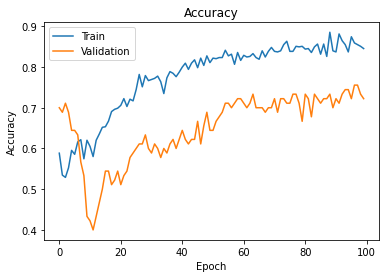

In [136]:
axis = plt.plot(fft_history.history['accuracy'])
plt.plot(fft_history.history['val_accuracy'])

plt.title("Accuracy")
plt.legend(["Train", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

(0.6, 1.0)

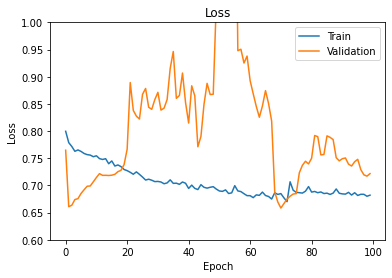

In [137]:
axis = plt.plot(rnn_history.history['loss'])
plt.plot(rnn_history.history['val_loss'])

plt.title("Loss")
plt.legend(["Train", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([0.6, 1.0])

(0.0, 2.0)

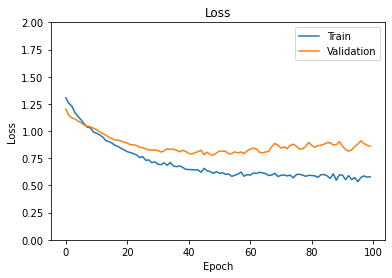

In [138]:
axis = plt.plot(fft_history.history['loss'])
plt.plot(fft_history.history['val_loss'])

plt.title("Loss")
plt.legend(["Train", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([0, 2])

We now run the test set (derived from the training set) to evaluate the expected accuracy.

In [139]:
for filename in [rnn_filename, fft_filename]:
  clf = load_model(filename)
  ttest_predict = clf.predict(ttest_feats)

  ttest_predict = np.array([1 if label >= 0.5 else 0 for label in ttest_predict])
  ttest_acc = accuracy_score(ttest_labels, ttest_predict)

  display("The test accuracy is", ttest_acc)
  display(ttest_predict)

'The test accuracy is'

0.6888888888888889

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0])

'The test accuracy is'

0.7222222222222222

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0])

### Predict Test Set using Deep Learning 
We run our deep learning model on the unlabeled test set.



In [140]:
def run_rnn_prediction(clf_file, data):
    clf = load_model(clf_file)
    
    # automatically return NaN for epochs with NaN 
    nan_indices = set(np.argwhere(np.isnan(data))[:, 0])    
    
    n_epochs = data.shape[0]
    predict_labels = []

    if nan_indices:
        valid_epochs = [x for x in range(0, n_epochs) if x not in nan_indices]
        for epoch in range(0, n_epochs):
            if epoch in valid_epochs:
                prediction = clf.predict(np.array([data[epoch, :, :]]))
                predict_labels.append(prediction[0][0])
            else:
                print("Epoch ", epoch, " contains NaN and cannot be predicted for.")
                predict_labels.append(np.nan)
    else:
        predict_labels = clf.predict(data)
    return predict_labels

In [141]:
rnn_test_predict = run_rnn_prediction(rnn_filename, rnn_test_data)
np.save('q1_rnn_test_outputs.npy', rnn_test_predict)

rnn_test_predict = np.array([1 if label >= 0.5 else 0 for label in rnn_test_predict])
np.save('q1_rnn_test_labels.npy', rnn_test_predict)

Epoch  169  contains NaN and cannot be predicted for.


In [142]:
fft_test_predict = run_rnn_prediction(fft_filename, rnn_test_data)
np.save('q1_fft_test_outputs.npy', fft_test_predict)

fft_test_predict = np.array([1 if label >= 0.5 else 0 for label in fft_test_predict])
np.save('q1_fft_test_labels.npy', fft_test_predict)

Epoch  169  contains NaN and cannot be predicted for.


## Deploying to Mobile using TFLite

In [143]:
import tensorflow as tf

We load the trained model and convert it into a `.tflite` model.  We load the model into the Python interpreter for inference.

In [146]:
keras_filename = rnn_filename
keras_model = load_model(keras_filename)
tflite_filename = './models/tflite_model.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

with tf.io.gfile.GFile(tflite_filename, 'wb') as f:
  f.write(tflite_model)

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)


INFO:tensorflow:Assets written to: /tmp/tmp8e3snbit/assets


INFO:tensorflow:Assets written to: /tmp/tmp8e3snbit/assets


[{'name': 'input_5', 'index': 0, 'shape': array([  1, 256,   4], dtype=int32), 'shape_signature': array([ -1, 256,   4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 55, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [147]:
def run_tflite_prediction(interpreter, data):
    
    # automatically return NaN for epochs with NaN 
    nan_indices = set(np.argwhere(np.isnan(data))[:, 0])    
    
    n_epochs = data.shape[0]
    predict_labels = []

    if nan_indices:
        valid_epochs = [x for x in range(0, n_epochs) if x not in nan_indices]
        for epoch in range(0, n_epochs):

            if epoch in valid_epochs:

                interpreter.set_tensor(input_details[0]['index'], 
                                       tf.cast(np.array([data[epoch, :, :]]), dtype=np.float32))
                interpreter.invoke()
                prediction = interpreter.get_tensor(output_details[0]['index'])
                predict_labels.append(prediction[0][0])
            else:
                print("Epoch ", epoch, " contains NaN and cannot be predicted for.")
                predict_labels.append(np.nan)
    else:
        predict_labels = clf.predict(data)
    
    return predict_labels

In [148]:
tflite_test_predict = run_tflite_prediction(interpreter, rnn_test_data)
np.save('q1_tflite_test_outputs.npy', tflite_test_predict)
tflite_test_predict

tflite_test_predict = np.array([1 if label >= 0.5 else 0 for label in tflite_test_predict])
np.save('q1_tflite_test_labels.npy', tflite_test_predict)

Epoch  169  contains NaN and cannot be predicted for.
